In [1]:
# import anything we need in this notebook
using MsUtils, Compose, Colors
import LujiaLt
import LujiaLt.FEM; Lfem = LujiaLt.FEM
;

# Introduction to Approximation

In this notebook we collect the computational examples associated with Chapters 3 and 4 of *Multiscale Simulation*. 

**Remark:** These codes use some elementary functional style constructs. 
These may initially require some getting used to, but in the long run they
make for code that is brief, readable and less likely to contain bugs.
In particular, Julia encourages to avoid `if` statements and instead use
its dispatch mechanism. This is a paradigm that makes for simple and 
elegant code.

## Requirements

* `Compose.jl`; to produce PDFs the latest master needs to be checked out
* `Colors.jl`

## Model

The homogeneous lattice model is
$$
    E(u) = \sum_{\ell \in \Lambda^{\rm hom}} \sum_{i = 1}^3 \phi\big( D_{a_i} u(\ell) \big)
        = \sum_{b \in B^{\rm hom}} \phi( Du_b ).
$$
We will use $\phi(r) = \sin^2( \pi r )$ throughout, which models an 
anti-plane nearest-neighbour pair interaction. 

We can introduce a point defect by introducing additional lattice sites and
associated bonds. A screw dislocation is introduced by adding a *pre-strain* 
to the bonds.  In order to implement only one model, we will describe both
of these within the same framework.

Let $\Lambda$ be a point defect reference configuration and $B$ an
associated set of nearest-neighbour bonds. Specifically we consider two
cases:

* *Homogeneous lattice:* $\Lambda^{\rm hom} = A \mathbb{Z}^2$ and 
    $B^{\rm hom} = \{ (i,j) \in \Lambda^2 : |i-j| = 1 \}$.
* *Interstitial-type defect:* $\Lambda^{\rm int} = \Lambda^{\rm hom} \cup \{\xi\}$, where $\xi = (1/2,0)$ or nearby is the defect site
and $B^{\rm int} = \{(i,j) \in \Lambda^2 : |i-j| \leq 1 \}$.

The pre-strain is a map ${\sf e} : B \to \mathbb{R}$. The energy is now given by
$$
  E(u) = \sum_{b \in B} \phi( {\sf e}_b + Du_b ) - \phi( {\sf e}_b ).
$$

We define the two benchmark problems through specifying $\Lambda, B, {\sf e}$:

* **Point defect case (interstitial)** 
    - $\Lambda = \Lambda^{\rm int}$
    - $B = B^{\rm int}$
    - ${\sf e}_{(i,j)} = 1 - |i-j|$
* **Screw dislocation case** 
    - $\Lambda = \Lambda^{\rm hom}$
    - $B = B^{\rm hom}$
    - ${\sf e}_{(i,j)} = (\frac{1}{2\pi} \arg(i-\xi) - \frac{1}{2\pi}\arg(j-\xi))~{\rm mod}~(-1/2, 1/2]$

More details about these choices can be found in Chapters 3 and 4 of the book.


## ATM Approximation

We first consider the purely atomistic approximation where only the
admissible displacements are restricted. For $R \in \mathbb{N}$ the
computational domain is given by
$$
   \Omega_R = \Lambda \cap [-R+1, R]^2
$$
with Dirichlet conditions (clamped) on the boundary sites. 



In [2]:
# [1] Preliminaries

# default interstitial position
const ξi = [0.5; 0.0]
# default screw core position
const ξs = [0.5; sqrt(3)/4]
# off-centre defect positions, to break symmetry
const ξi_off = [0.3; 0.2]
const ξs_off = [0.4; 0.35]

# a Julia hack that allows us to do dispatch instead 
NoDefectT = Val{:none}; const NoDefect = NoDefectT()
ScrewT = Val{:screw}; const Screw = ScrewT()
InterstitialT = Val{:int}; const Interstitial = InterstitialT()
NoneOrInt = Union{NoDefectT, InterstitialT}
NoneOrScrew = Union{NoDefectT, ScrewT}

"distance of several points from a centre"
dist(X::Matrix, x0) = sqrt(sumabs2(X .- x0, 1))

# [2] Domain

"""computational domain; returns (x, y) coordinate 
vectors of lattice points"""
domain(R, ::NoneOrScrew; defcore=ξs) = LujiaLt.lattice_ball(R=R, A=LujiaLt.Atri)[1]
domain(R, ::InterstitialT; defcore=ξi) = [domain(R, NoDefect) defcore]

# [3] bonds

"If v : X → R, then fdiff(v) : Bonds → R storing Dv_b"
fdiff(v::Vector, B::Tuple) = v[B[2]] - v[B[1]]
fdiff(v::Matrix, B::Tuple) = v[:, B[2]] - v[:, B[1]]
fdiff(v, B::Matrix) = fdiff(v, mat2tup(B))

"""bonds within a computational domain: 
find all the Delaunay edges with length <= 1"""
function bonds(X) 
    E = Lfem.edges(Lfem.Triangulation(X))
    E = E[:, find(sumabs2(fdiff(X, E), 1) .<= 1.1)]
    return mat2tup(E)
end

"bond midpoints"
midpoints(X, B) = 0.5*(X[:, B[1]] + X[:, B[2]])

"distance of bond mid-points from x0"
bonddist(X::Matrix, B::Tuple, x0) = dist( midpoints(X, B), x0 )


# [4] prestrain is a function of lattice positions

"compute prestrains"
prestrain(X, B, ::NoneOrInt) = 1.0 - sqrt( sumabs2(fdiff(X, B), 1) )[:]
predictor(X, ::ScrewT; xc = ξs) = predictor_screw(X .- xc)
prestrain(X, B, ::ScrewT; xc = ξs) = prestrain_screw(X .- xc, B)
arg(x, y) = imag(log(x + im * y))
predictor_screw(X) = arg(X[1,:][:], X[2,:][:]) / (2*π)
prestrain_screw(X, B) = mod(fdiff(predictor_screw(X), B) + 0.5, 1) - 0.5

# [5] last aspect of geometry: free indices
Ifree(X, R; xc = [0.0;0.0]) = find(dist(X, xc) .< R)
Iclamp(X, R; xc = [0.0;0.0]) = find(dist(X, xc) .>= R)
;


### Testing the geometry implementations

We test the geometry implementation by creating an interstitial geometry
and a screw dislocation geometry and plotting both.

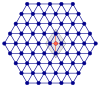

In [3]:
# Interstitial
X = domain(4.0, Interstitial)
B = bonds(X)
ee = prestrain(X, B, Interstitial)
ctx = plot_int(X, B, ee, plotwidth=10cm);

Two more plots, that go straight into the book.

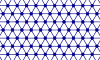

In [4]:
# homogeneous triangular lattice
X = domain(10.0, NoDefect)
B = bonds(X)
axis = [-5.3; 5.3; -3.2; +3.2]
ctx = compose( context(axis),
               compose_atoms(X, [0.15], 0.5, axis, MsUtils.blue),
               compose_bonds(X, B, 0.6, MsUtils.blue, axis) )
draw(MsUtils.auto_img(PDF, "ex-trilattice.pdf", axis, 10cm), ctx)
draw(MsUtils.auto_img(SVG, axis, 10cm), ctx)

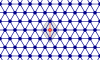

In [5]:
# point defect in infinite medium
X = domain(10.0, Interstitial)
B = bonds(X)
ee = prestrain(X, B, Interstitial)
ctx = plot_int( X, B, ee, axis=[-ξi[1]-4.0; ξi[1]+5.0; ξi[2]-3; ξi[2]+3], 
filename="ex_int_atm.pdf", printwidth=10cm, plotwidth=10cm );

### Implementation of the energies

we have completed all of the geometry assembly and can now turn to the energy.

In [6]:

# [6] Model type : to collect all the information
#     the construction is produced below
type AtmModel{T}
    R   # domain parameter
    X   # lattice coordinates
    B   # bonds
    e   # pre-strains
    Ifree   # free dofs
    defect::T  # type of defect
end

function AtmModel(; R=5, defect = NoDefect, kwargs...)
    X = domain(R, defect; kwargs...)
    B = bonds(X)
    return AtmModel(R, X, B, prestrain(X, B, defect), Ifree(X, R-1.1), defect)
end

"number of lattice sites in the computational domain"
nsites(m::AtmModel) = size(m.X, 2)
"number of dofs"
ndofs(m::AtmModel) = length(m.Ifree)

# [7] Energy as a function of displacement
#
"NN pair potential (we use the same potential for all experiments)" 
ϕ(r) = sin(r*π).^2
"first derivative of ϕ"
Dϕ(r) = π * sin(2*r*π)
"second derivative of ϕ"
D²ϕ(r) = 2*π^2 * cos(2*r*π)

"potential energy (difference), as function of displacement"
energy_disp(m, U) = sum_kbn( ϕ(m.e + fdiff(U[:], m.B)) - ϕ(m.e) )

"gradient of potential energy"
grad_disp(m, U) = _grad_(m.B, Dϕ(m.e + fdiff(U[:], m.B)))
_grad_(B, dϕ) = binsum([dϕ; -dϕ], [B[2]; B[1]])

"hessian as function of displacement"
hess_disp(m, U) = _hess_(m.B, D²ϕ(m.e + fdiff(U[:], m.B)))
_hess_(B, hϕ) = sparse( [B[1]; B[2]; B[1]; B[2]], 
                        [B[1]; B[2]; B[2]; B[1]],  
                        [  hϕ;   hϕ;  -hϕ; -hϕ] )

# [8] displacement ↔ dof conversion
#
"create a dof vector from a displacement vector"
disp2dof(m, U) = U[m.Ifree]

"create a full displacement vector from a dof vector"
function dof2disp(m, W)
    U = zeros(nsites(m))
    U[m.Ifree] = W[:]
    return U
end

"energy as function of dofs"
energy(m, W) = energy_disp(m, dof2disp(m, W))
"gradient as function of dofs"
grad(m, W) = grad_disp(m, dof2disp(m, W))[m.Ifree]
"hessian as function of dofs"
hess(m, W) = hess_disp(m, dof2disp(m, W))[m.Ifree, m.Ifree]


# [9] Basic Newton solver 
#     (this will be sufficient for our purposes here)
#
function solve(m; x = zeros(ndofs(m)), show = false)
    show && @printf("------Newton Iteration------\n")
    nit = 0
    for nit = 0:12
        ∇E = grad(m, x)
        show && @printf("%d : %4.2e \n", nit, norm(∇E, Inf))
        norm(∇E, Inf) < 1e-8 && break
        x = x - hess(m, x) \ ∇E
    end
    nit == 12 && warn("the Newton iteration did not converge")
    show && @printf("----------------------------\n")
    return x
end
;

### Testing the implementation

We perform some basic tests to make sure the implementation is correct. 
The basic philosophy of these tests is that, if the energy, gradient and 
hessian are all consistent then the implementation is likely correct. 
Hense we perform a finite difference test. We will test all partial derivatives
for decreasing steps $h$.

Note that
$f'(x) = \frac{f(x+h) - f(x)}{h} + O(h)$, but when we take floating-point errors 
into account, then we obtain
$$
    f'(x) = \frac{f(x+h) - f(x)}{h} + O\left( h + \frac{\epsilon}{h} \right),
$$
where $\epsilon$ denotes floating point accuracy. Hence, as $h$ decreases we first see an improvement but eventually a deterioration of the test agreement.

These tests use `fdtest`, which is implemented in `MsUtils.jl`.

In [7]:

# run the FD test : change `defect` to :none, :int, :screw
# to test the three implementations
m = AtmModel(R = 10, defect = Interstitial)
println("Test Energy as function of displacement")
fdtest(0.1 * rand(nsites(m)), x->energy_disp(m,x), x->grad_disp(m,x), x->hess_disp(m,x))
# println("Test Energy as function of dofs")
# fdtest(0.1 * rand(ndofs(m)), x->energy(m,x), x->grad(m,x), x->hess(m,x))


Test Energy as function of displacement
    h  | ∇E-error   ∇²E-error  
-------|----------------------- 
 1e-02 | 6.52e-01   1.55e+00  
 1e-03 | 6.51e-02   1.62e-01  
 1e-04 | 6.51e-03   1.63e-02  
 1e-05 | 6.51e-04   1.63e-03  
 1e-06 | 6.51e-05   1.63e-04  
 1e-07 | 6.50e-06   1.63e-05  
 1e-08 | 4.73e-07   1.74e-06  
 1e-09 | 3.61e-06   2.85e-06  
 1e-10 | 3.30e-05   3.00e-05  
 1e-11 | 3.28e-04   2.93e-04  
 1e-12 | 3.29e-03   2.66e-03  


Our second test concerns the Newton scheme. If it is correctly 
implemented and if gradient and hessian are consistent (we just
tested this), then it should converge in 4-5 iterations at most.

In [8]:
# change `defect` to {NoDefect, Interstitial, Screw} for the three model problems
m = AtmModel(R = 20, defect=Screw)
solve( m; show=true, x = 0.1 * rand(ndofs(m)) );


------Newton Iteration------
0 : 9.57e+00 
1 : 1.10e+00 
2 : 2.95e-02 
3 : 1.32e-03 
4 : 2.27e-06 
5 : 5.90e-12 
----------------------------


### Visualise the Solutions

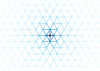

In [9]:
# interstitial
m = AtmModel(R = 20, defect=Interstitial)
u = dof2disp(m, solve(m))
Du = fdiff(u, m.B)
axis = [ξi[1]-7; ξi[1]+7; ξi[2]-5; ξi[2]+5]
MsUtils.plot_strain(m.X, m.B, log(abs(m.e+Du)+2e-4); 
                    axis=axis, cmap = colormap("blues"),
                    filename = "apx-strain-int.pdf", printwidth=12cm);

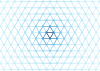

LoadError: LoadError: UndefVarError: plot_displacement not defined
while loading In[10], in expression starting on line 10

In [10]:
# screw dislocation
m = AtmModel(R = 20, defect=Screw)
u = dof2disp(m, solve(m))
Du = fdiff(u, m.B)
axis = [ξs[1]-7; ξs[1]+7; ξs[2]-5; ξs[2]+5]
MsUtils.plot_strain(m.X, m.B, log(abs(m.e+Du)+3e-2); 
                    axis=axis, cmap = colormap("blues"),
                    filename = "apx-strain-screw.pdf", printwidth=12cm);
u_tot = predictor(m.X, Screw) + u
MsUtils.plot_displacement(m.X, m.B, u_tot);

### Testing the rate of decay of the solutions

An alternative visualisation, where one can see a lot more is to just plot the decay in terms of distance from the origin.


In [11]:
R = 50
Rp = 20
mi = AtmModel(R = R, defect=Interstitial, defcore = ξi_off)
ui = dof2disp(mi, solve(mi))
Dui = fdiff(ui, mi.B)
ri = bonddist(mi.X, mi.B, ξi_off)
I = find(ri .<= Rp)
ri = ri[I]; Dui = Dui[I]

# p = plot_envelope(ri, abs(Dui), Rp, 
#                 axis=[0.5, Rp, 1e-6, 1],
#                 slope = [5; 18; 0.05; -2.0],
#                 label = [L"$\sim r_b^{-2}$", 10.0, 1.5e-3],
#                 title = "Interstitial")
# display(p)
# save("ex-decay-int.pdf", p)
;

In [12]:
ms = AtmModel(R = R, defect=Screw, defcore = ξs_off)
us = dof2disp(ms, solve(ms))
Dus = fdiff(us, ms.B)
rs = bonddist(ms.X, ms.B, ξs_off)
I = find(rs .<= Rp)
rs = rs[I]; Dus = Dus[I]; es = ms.e[I]

# pscrew = plot_envelope(rs, abs(Dus), Rp, 
#                 axis=[0.5, Rp, 1e-6, 1],
#                 slope = [5; 18; 0.1; -2.0],
#                 label = [L"$\sim r_b^{-2}$", 10.0, 3e-3],
#                 title = "Screw Dislocation" )
# display(pscrew)
# save("ex-decay-screw.pdf", pscrew)
;

In [15]:
include("MsUtils.jl")
# using PyPlot
# or, again, just the envelope and ignoring the data points
xbins = logspace(0, log10(Rp*0.99), 15)
xi, yi = MsUtils.envelope(ri, abs(Dui), xbins)
xs, ys = MsUtils.envelope(rs, abs(Dus), xbins)
xstot, ystot = MsUtils.envelope(rs, abs(es + Dus), xbins)
p = Axis([
    Plots.Linear(xi, yi, style="thick", legendentry="interstitial");
    Plots.Linear(xs, ys, style="thick", legendentry="screw, corrector");
    Plots.Linear(xstot, ystot, style="green, thick", legendentry="screw, total");
    MsUtils.plot_slope(6.0, 20.0, 0.5, -1.0);
    Plots.Node(L"\sim r_b^{-1}", 12.0, 1e-1);
    MsUtils.plot_slope(6.0, 20.0, 0.07, -2.0);
    Plots.Node(L"\sim r_b^{-2}", 10.0, 3e-3);
        ],
        ymode="log", xmode="log",
        xlabel=L"$r_b$", 
        ylabel = "strain (envelope)", 
        legendPos="south west" )
# display(p)
save("ex-decay-all.pdf", p)

LoadError: LoadError: UndefVarError: @L_str not defined
while loading In[15], in expression starting on line 21

### Testing the Convergence Rate for the `ATM` Model


